In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
import datetime
import requests
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
py.init_notebook_mode(connected=True)

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

In [2]:
import requests
data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/').json()
df_data = pd.json_normalize(data_json['data']['rawPatientData'])
df_data.drop(df_data.iloc[:, -5:], inplace = True, axis = 1) 
df_data.drop(['onsetEstimate'], axis=1,inplace = True)

In [3]:
df_data_state = df_data.loc[df_data['state'] == "Kerala"]
df_data_state.index = np.arange(1,len(df_data_state)+1)
df_data_state

,patientId,reportedOn,ageEstimate,gender,city,district,state,status,notes
1,1,30/01/2020,20,female,Thrissur,Thrissur,Kerala,Recovered,Travelled from Wuhan
2,2,02/02/2020,,,Alappuzha,Alappuzha,Kerala,Recovered,Travelled from Wuhan
3,3,03/02/2020,,,Kasaragod,Kasaragod,Kerala,Recovered,Travelled from Wuhan
4,35,08/03/2020,24,male,Ranni,Pathanamthitta,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha
5,36,08/03/2020,54,male,Ranni,Pathanamthitta,Kerala,Recovered,Travelled from Italy on 29/02/2020 through Doha
...,...,...,...,...,...,...,...,...,...
465,26526,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
466,26527,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
467,26528,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited
468,26529,26/04/2020,,,,Kottayam,Kerala,Hospitalized,Details awaited


## Gender Details

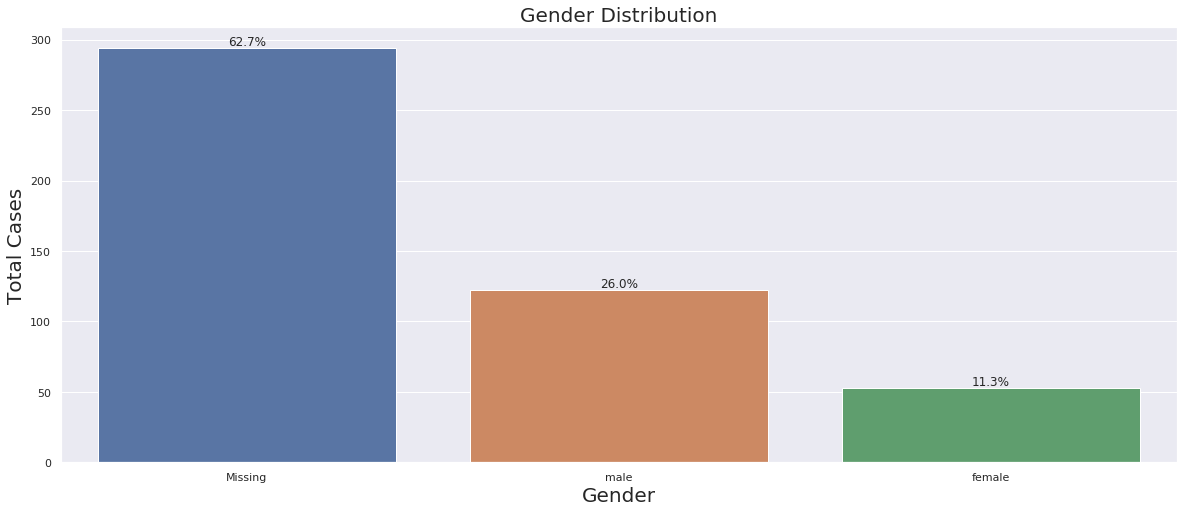

In [33]:
df_data_state['gender'].replace('', np.nan, inplace=True)
df_data_state.gender.fillna('Missing',inplace = True)
sns.color_palette("bright")
plt.figure(figsize=(20,8))
sns.countplot(data=df_data_state,x='gender',order=df_data_state['gender'].value_counts().index)
plt.title('Gender Distribution', fontsize = 20)
plt.xlabel('Gender', fontsize = 20)
plt.ylabel('Total Cases', fontsize = 20)
order2 = df_data_state['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_data_state.gender.dropna().count() )
    plt.text(i,count+2,strt,ha='center')

## Age Group Analysis

In [5]:

df_data_state['ageEstimate'].replace('', np.nan, inplace=True)
df_data_state.ageEstimate.fillna(-1,inplace = True)
df_data_state['ageEstimate'] = pd.cut(x=df_data_state['ageEstimate'].astype(float), bins=[0, 10, 20, 30, 40,50,60,70,80,90], labels=['10s', '20s', '30s', '40s','50s','60s','70s','80s','90s'])
df_data_state['ageEstimate'] = df_data_state['ageEstimate'].cat.add_categories('Missing')
df_data_state.ageEstimate.fillna('Missing',inplace = True)

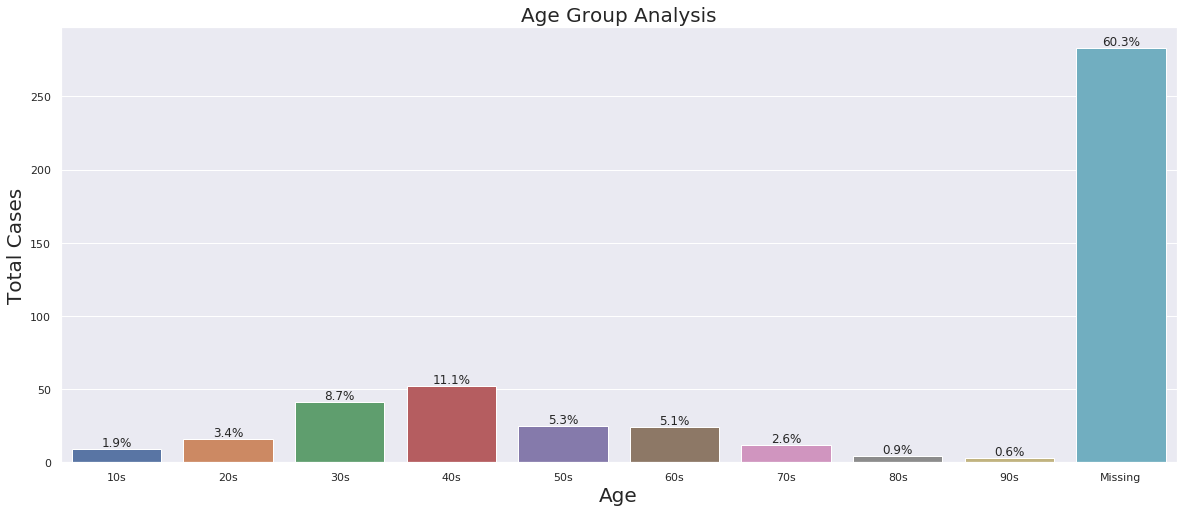

In [32]:

sns.color_palette("deep")
plt.figure(figsize=(20,8))
sns.countplot(data=df_data_state,x='ageEstimate',order=df_data_state['ageEstimate'].value_counts(sort=False).index)
plt.title('Age Group Analysis', fontsize = 20)
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Total Cases', fontsize = 20)
order2 = df_data_state['ageEstimate'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_data_state.ageEstimate.dropna().count() )
    plt.text(i,count+2,strt,ha='center')

##                        District wise Analysis


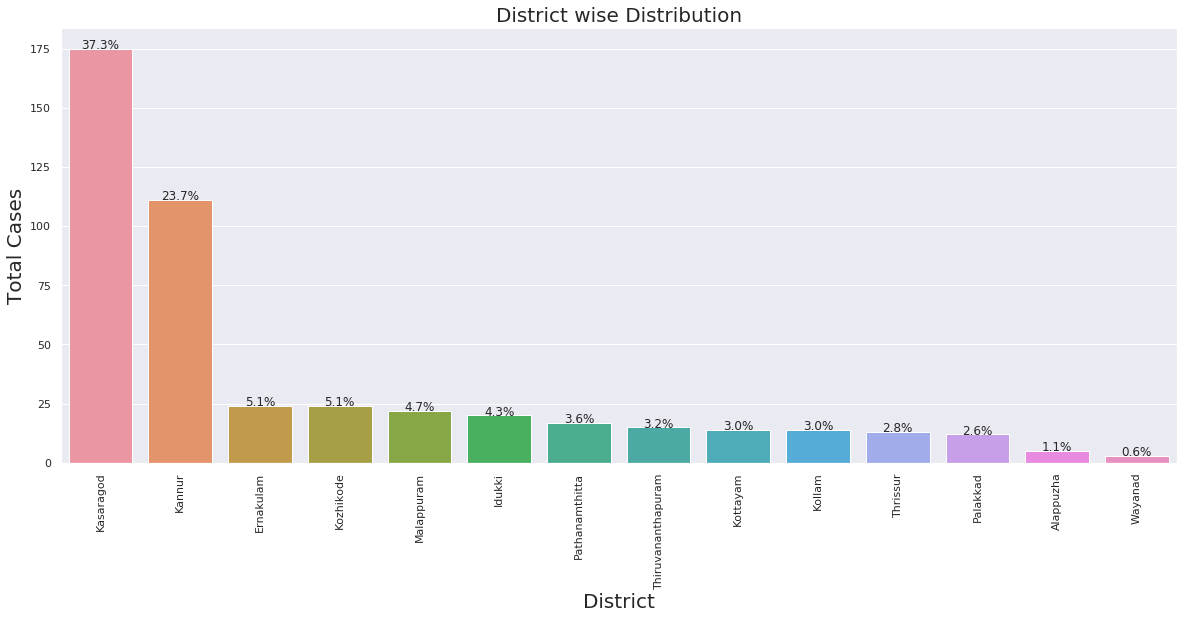

In [34]:
plt.figure(figsize=(20,8))
sns.color_palette("husl")
sns.countplot(data=df_data_state,x='district',order=df_data_state['district'].value_counts().index)
plt.title('District wise Distribution',fontsize = 20)
plt.xlabel('District',fontsize = 20 )
plt.ylabel('Total Cases',fontsize = 20)
order2 = df_data_state['district'].value_counts()
plt.xticks(rotation = 90)
for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_data_state.district.dropna().count() )
    plt.text(i,count,strt,ha='center')